# Preliminary: SHAP and XGBoost 

In [1]:

import shap
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import KFold, train_test_split, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV


## Load dataset


In [2]:
waterqualitypath = "../data/plankton-patrol/Plankton Patrol/Data/plankton-patrol_ChesapeakeWaterQuality.csv"
data = pd.read_csv(waterqualitypath)
data.info()

C:\Users\pushk\AppData\Local\Temp\ipykernel_29932\2510223144.py:2: DtypeWarning: Columns (1,10,11,12,13,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(waterqualitypath)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162314 entries, 0 to 2162313
Data columns (total 26 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   CBSeg2003            object
 1   EventId              object
 2   Cruise               object
 3   Program              object
 4   Project              object
 5   Agency               object
 6   Source               object
 7   Station              object
 8   SampleDate           object
 9   SampleTime           object
 10  TotalDepth           object
 11  UpperPycnocline      object
 12  LowerPycnocline      object
 13  Depth                object
 14  Layer                object
 15  SampleType           object
 16  SampleReplicateType  object
 17  Parameter            object
 18  Qualifier            object
 19  MeasureValue         object
 20  Unit                 object
 21  Method               object
 22  Lab                  object
 23  Latitude             object
 24  Longitude            obj

### Inspect column names

In [3]:
data.columns

Index(['CBSeg2003', 'EventId', 'Cruise', 'Program', 'Project', 'Agency',
       'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth',
       'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType',
       'SampleReplicateType', 'Parameter', 'Qualifier', 'MeasureValue', 'Unit',
       'Method', 'Lab', 'Latitude', 'Longitude', 'TierLevel'],
      dtype='object')

In [4]:
data["Qualifier"] = data["Qualifier"].replace(np.nan, "=")


columns_to_exclude = ["Parameter", "MeasureValue", "Unit"]
unique_columns = [col for col in data.columns if col not in columns_to_exclude]

df_unique = data[unique_columns].drop_duplicates(subset="EventId")
print(df_unique.shape, data.shape)
data_r = data.pivot_table(
    index=["EventId"], columns="Parameter", values="MeasureValue", aggfunc="first"
).reset_index()
exclude_from_pivoted = ["Parameter", "MeasureValue", "Unit", "SampleDate", "SampleTime"]
pivoted_columns = data_r.columns.tolist()
for ce in exclude_from_pivoted:
    if ce in pivoted_columns:
        pivoted_columns.remove(ce)
data_m = pd.merge(df_unique, data_r, on="EventId", how="left")


print(data_m.columns, data_m.shape)

(20855, 23) (2162314, 26)
Index(['CBSeg2003', 'EventId', 'Cruise', 'Program', 'Project', 'Agency',
       'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth',
       'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType',
       'SampleReplicateType', 'Qualifier', 'Method', 'Lab', 'Latitude',
       'Longitude', 'TierLevel', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'Parameter', 'SALINITY', 'SECCHI',
       'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS',
       'TURB_NTU', 'VSS', 'WTEMP'],
      dtype='object') (20855, 58)


In [5]:
columns_to_drop = ['EventId']

# Drop the specified columns
data_md = data_m.drop(columns=columns_to_drop)


In [6]:
data_md.head()

,CBSeg2003,Cruise,Program,Project,Agency,Source,Station,SampleDate,SampleTime,TotalDepth,...,SPCOND,TDN,TDP,TN,TON,TP,TSS,TURB_NTU,VSS,WTEMP
0,CB1TF,BAY451,TWQM,MAIN,MDDNR,MDDNR,CB1.1,12/13/2006,10:58:00,7.0,...,195.0,1.67,0.0181,1.7183,0.2773,0.0308,7.3,NaN,2.0,5.5
1,CB1TF,BAY452,TWQM,MAIN,MDDNR,MDDNR,CB1.1,1/12/2007,13:00:00,5.5,...,137.0,1.41,0.0168,1.4958,0.2498,0.0384,11.3,NaN,5.3,5.3
2,CB1TF,BAY454,TWQM,MAIN,MDDNR,MDDNR,CB1.1,3/14/2007,10:41:00,7.0,...,234.0,1.98,0.0183,2.055,0.2902,0.0305,7.4,NaN,3.2,2.6
3,CB1TF,BAY456,TWQM,MAIN,MDDNR,MDDNR,CB1.1,4/11/2007,10:32:00,6.5,...,185.0,1.35,0.0098,1.4153,0.1653,0.0237,8.0,NaN,2.8,7.6
4,CB1TF,BAY457,TWQM,MAIN,MDDNR,MDDNR,CB1.1,4/26/2007,11:46:00,5.5,...,142.0,1.04,0.0132,1.1297,0.1568,0.0331,15.0,NaN,3.0,13.9


In [7]:
pivoted_columns

['EventId',
 'CHLA',
 'DIN',
 'DO',
 'DOC',
 'DON',
 'DOP',
 'DO_SAT_P',
 'FSS',
 'KD',
 'NH4F',
 'NO23F',
 'NO2F',
 'NO3F',
 'PC',
 'PH',
 'PHEO',
 'PIP',
 'PN',
 'PO4F',
 'PP',
 'SALINITY',
 'SECCHI',
 'SIF',
 'SIGMA_T',
 'SPCOND',
 'TDN',
 'TDP',
 'TN',
 'TON',
 'TP',
 'TSS',
 'TURB_NTU',
 'VSS',
 'WTEMP']

In [8]:
set_numeric = [
    "TotalDepth",
    "UpperPycnocline",
    "LowerPycnocline",
    "Depth",
    "Latitude",
    "Longitude",
    "MeasureValue",
    "CHLA",
    "DIN",
    "DO",
    "DOC",
    "DON",
    "DOP",
    "DO_SAT_P",
    "FSS",
    "KD",
    "NH4F",
    "NO23F",
    "NO2F",
    "NO3F",
    "PC",
    "PH",
    "PHEO",
    "PIP",
    "PN",
    "PO4F",
    "PP",
    "Parameter",
    "SALINITY",
    "SECCHI",
    "SIF",
    "SIGMA_T",
    "SPCOND",
    "TDN",
    "TDP",
    "TN",
    "TON",
    "TP",
    "TSS",
    "TURB_NTU",
    "VSS",
    "WTEMP",
]
# set_string = ['
set_date = ["SampleDate", "SampleTime"]


def combine_date_time_strings(df, date_col, time_col):
    # Combine date and time strings
    combined_col = df[date_col] + " " + df[time_col]
    # Convert the combined string to datetime
    datetime_col = "Sample"

    df[datetime_col] = pd.to_datetime(combined_col, errors="coerce")
    df[datetime_col + "_year"] = df[datetime_col].dt.year
    df[datetime_col + "_month"] = df[datetime_col].dt.month
    df[datetime_col + "_day"] = df[datetime_col].dt.day
    df[datetime_col + "_hour"] = df[datetime_col].dt.hour
    df[datetime_col + "_minute"] = df[datetime_col].dt.minute
    df[datetime_col + "_second"] = df[datetime_col].dt.second
    newcolnames = [
        f"{datetime_col}_year",
        f"{datetime_col}_month",
        f"{datetime_col}_day",
        f"{datetime_col}_hour",
        f"{datetime_col}_minute",
        f"{datetime_col}_second",
    ]
    # Drop the original date, time, and combined datetime columns
    df.drop(columns=[date_col, time_col, datetime_col], inplace=True)

    return df, newcolnames


# Function to convert columns to appropriate types
def convert_dtypes(df):
    for col in df.columns:
        df[col] = df[col].replace("nan", np.nan)
        # print(df[col][564463])
        print(f"converting column {col}", end="\t")
        print(df[col].dtype)

        if col not in (set_numeric + set_date):
            df[col] = pd.Categorical(df[col])
            print("Categorical")
        elif col in set_numeric:
            # try:
            # Try converting to numeric (float)
            df[col] = pd.to_numeric(df[col], errors="coerce")
            print("Numeric")
        # except (ValueError, TypeError):
        # try:
        elif col in set_date:
            print("Date, skipped")
            pass
            # Try converting to datetime (date)
            # df[col] = pd.to_datetime(df[col], errors='coerce')
            # except (ValueError, TypeError):
            # Check for categorical
            # unique_ratio = df[col].nunique() / df[col].count()
            # if unique_ratio < 0.2:  # heuristic for categorical, adjustable threshold
            # Convert to string if not numeric, date, or categorical
        else:
            print(f"{col}: string")
            df[col] = df[col].astype(str)
            print("string")
        print(df[col].dtype)
    return df


# Apply the conversion function
datacopy = data_md.__deepcopy__()
data_conv = convert_dtypes(datacopy)
data_cleana, newcols = combine_date_time_strings(data_conv, "SampleDate", "SampleTime")
# Check the result
print(data_cleana.dtypes)
print(data_cleana.shape)
# data.dropna(axis='TotalDepth',how='all')
data_cleana = data_cleana[:-1]
print(data_cleana.shape)

# data_conv = convert_dtypes(data_conv)
# for col in data.columns:
#     # print(data[col])
#     if col not in (set_float + set_date):
#         data[col]= pd.Categorical(df[col])(data[col][1:])
#     # if col in set_string:
#     #     data[col][1:]=data[col][1:].astype("string")
#     if col in set_float:
#         data[col]= pd.to_numeric(data[col], errors='raise')
#     if col in set_date:
#         print(col)
#         data[col][1:]=pd.to_datetime(data[col][1:],errors='coerce')
#         # data[col]=data[col].dt.strftime(f'%m/%d/%Y')
data_cleana

converting column CBSeg2003	object
Categorical
category
converting column Cruise	object
Categorical
category
converting column Program	object
Categorical
category
converting column Project	object
Categorical
category
converting column Agency	object
Categorical
category
converting column Source	object
Categorical
category
converting column Station	object
Categorical
category
converting column SampleDate	object
Date, skipped
object
converting column SampleTime	object
Date, skipped
object
converting column TotalDepth	object
Numeric
float64
converting column UpperPycnocline	object
Numeric
float64
converting column LowerPycnocline	object
Numeric
float64
converting column Depth	object
Numeric
float64
converting column Layer	object
Categorical
category
converting column SampleType	object
Categorical
category
converting column SampleReplicateType	object
Categorical
category
converting column Qualifier	object
Categorical
category
converting column Method	object
Categorical
category
converting c

,CBSeg2003,Cruise,Program,Project,Agency,Source,Station,TotalDepth,UpperPycnocline,LowerPycnocline,...,TSS,TURB_NTU,VSS,WTEMP,Sample_year,Sample_month,Sample_day,Sample_hour,Sample_minute,Sample_second
0,CB1TF,BAY451,TWQM,MAIN,MDDNR,MDDNR,CB1.1,7.0,NaN,NaN,...,7.3,NaN,2.0,5.5,2006.0,12.0,13.0,10.0,58.0,0.0
1,CB1TF,BAY452,TWQM,MAIN,MDDNR,MDDNR,CB1.1,5.5,NaN,NaN,...,11.3,NaN,5.3,5.3,2007.0,1.0,12.0,13.0,0.0,0.0
2,CB1TF,BAY454,TWQM,MAIN,MDDNR,MDDNR,CB1.1,7.0,NaN,NaN,...,7.4,NaN,3.2,2.6,2007.0,3.0,14.0,10.0,41.0,0.0
3,CB1TF,BAY456,TWQM,MAIN,MDDNR,MDDNR,CB1.1,6.5,NaN,NaN,...,8.0,NaN,2.8,7.6,2007.0,4.0,11.0,10.0,32.0,0.0
4,CB1TF,BAY457,TWQM,MAIN,MDDNR,MDDNR,CB1.1,5.5,NaN,NaN,...,15.0,NaN,3.0,13.9,2007.0,4.0,26.0,11.0,46.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20849,TANMH,PART19,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,27.9,2019.0,8.0,21.0,12.0,19.0,0.0
20850,TANMH,PART19,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,25.9,2019.0,9.0,16.0,12.0,10.0,0.0
20851,TANMH,PART22,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,26.3,2022.0,7.0,6.0,10.0,10.0,0.0
20852,TANMH,PART22,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,28.7,2022.0,8.0,3.0,12.0,42.0,0.0


In [9]:
pivoted_columns= pivoted_columns+newcols
print(len(pivoted_columns), pivoted_columns)

41 ['EventId', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU', 'VSS', 'WTEMP', 'Sample_year', 'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute', 'Sample_second']


In [10]:
# pivoted_columns = [col for col in pivoted_columns if col in data_clean.columns]

# data_clean = data_clean.replace([np.inf, -np.inf], np.nan).dropna(
#     subset=[pivoted_columns]
# )
data_cleana = data_cleana.replace([np.inf, -np.inf], np.nan)


missing_percentage = data_cleana.isnull().mean()
print(missing_percentage)
clean_columns = data_cleana.columns.tolist()

# Drop columns where more than 95% of the data is missing
columns_to_drop = missing_percentage[missing_percentage > 0.90].index
print(columns_to_drop)
data_cleana = data_cleana.drop(columns=columns_to_drop)
data_clean = data_cleana.copy()
data_clean = data_cleana.dropna(subset=['CHLA'])
# data_clean = data_cleana.dropna(
#     subset=[
#         "CHLA",
#         "DIN",
#         "DO",
#         "DOC",
#         "DON",
#         "DOP",
#         "DO_SAT_P",
#         "FSS",
#         "KD",
#         "NH4F",
#         "NO23F",
#         "NO2F",
#         "NO3F",
#         "PC",
#         "PH",
#         "PHEO",
#         "PN",
#         "PO4F",
#         "PP",
#         "SALINITY",
#         "SECCHI",
#         "SIF",
#         "SIGMA_T",
#         "SPCOND",
#         "TDN",
#         "TDP",
#         "TN",
#         "TON",
#         "TP",
#         "TSS",
#         "VSS",
#         "WTEMP",
#     ]
# )
dropped_columns = [col for col in clean_columns if col not in data_clean.columns]

data_clean.info()

CBSeg2003        0.000000
Cruise           0.026278
Program          0.000048
Project          0.000048
Agency           0.000048
                   ...   
Sample_month     0.000096
Sample_day       0.000096
Sample_hour      0.000096
Sample_minute    0.000096
Sample_second    0.000096
Length: 61, dtype: float64
Index(['PIP', 'Parameter', 'TURB_NTU'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 17143 entries, 0 to 20817
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CBSeg2003            17143 non-null  category
 1   Cruise               16642 non-null  category
 2   Program              17143 non-null  category
 3   Project              17143 non-null  category
 4   Agency               17143 non-null  category
 5   Source               17143 non-null  category
 6   Station              17143 non-null  category
 7   TotalDepth           17128 non-null  float64 
 8   UpperPycnocl

In [11]:
print(dropped_columns)

['PIP', 'Parameter', 'TURB_NTU']


In [12]:

X, y = data_clean.drop(['CHLA'], axis=1), data_clean['CHLA']
# X = pd.get_dummies(X, drop_first=True) # TOO much memory
# Label encode categorical variables
for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes
X.shape, y.shape


((17143, 57), (17143,))

# Visualize data

In [14]:
import matplotlib.pyplot as plt
def visualize_param_map(df, parameter, path):
    latitude = df['Latitude']
    longitude = df['Longitude']
    cha = df[parameter]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(longitude, latitude, c=cha, cmap='coolwarm', marker='o')

    # Add a color bar
    plt.colorbar(scatter, label=f'{parameter} Values')

    # Add labels and title
    plt.title(f'{parameter} Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Display the plot
    plt.grid(True)
    # plt.show()
    plt.savefig(path)

Visualize parameters

C:\Users\pushk\AppData\Local\Temp\ipykernel_29932\2952524738.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


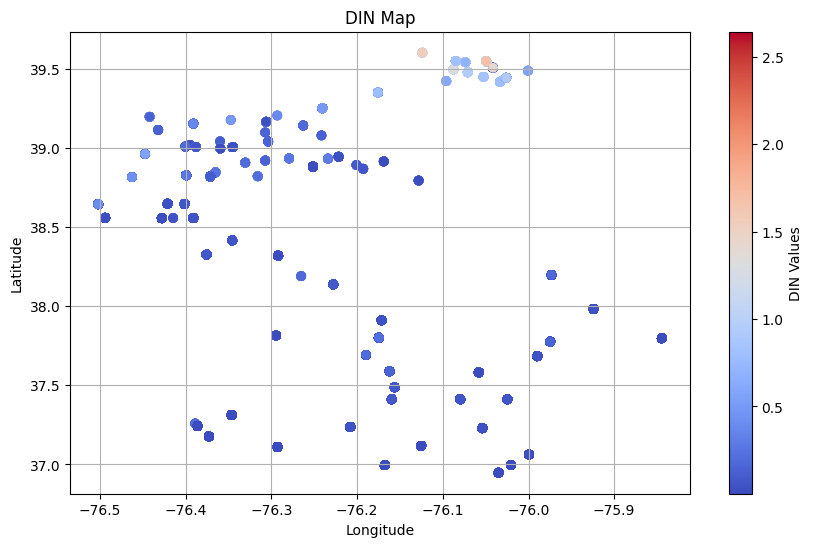

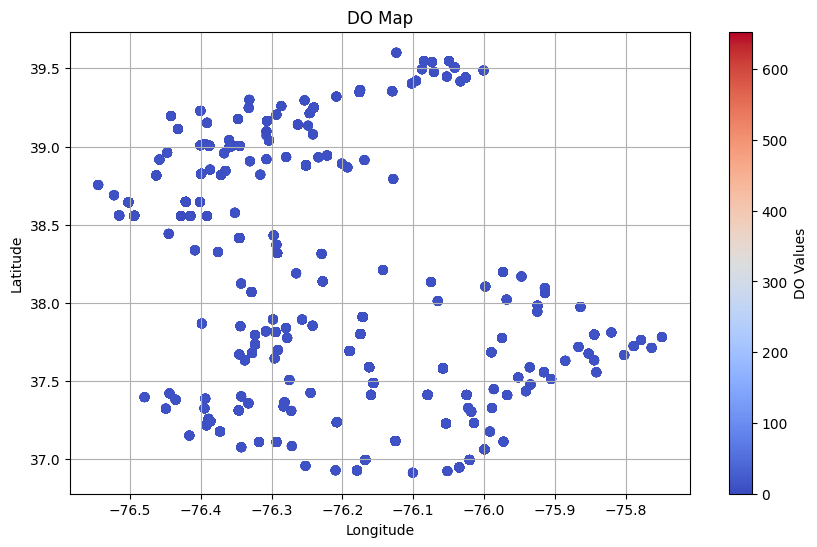

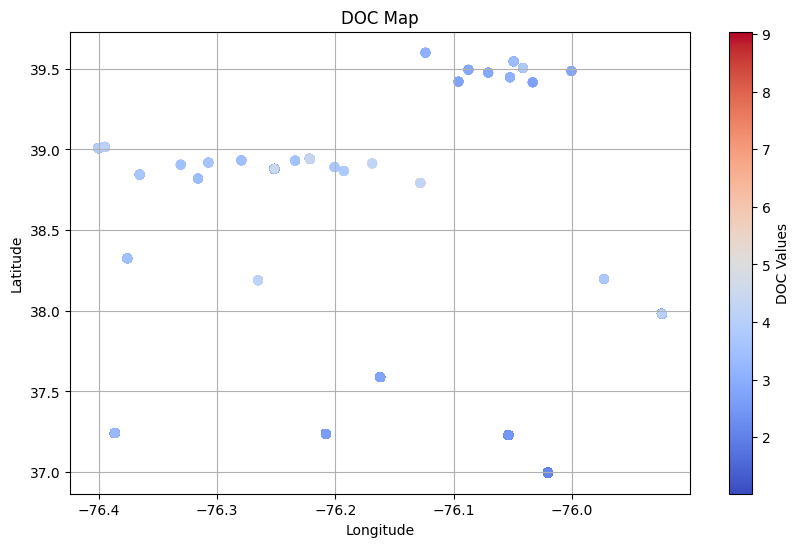

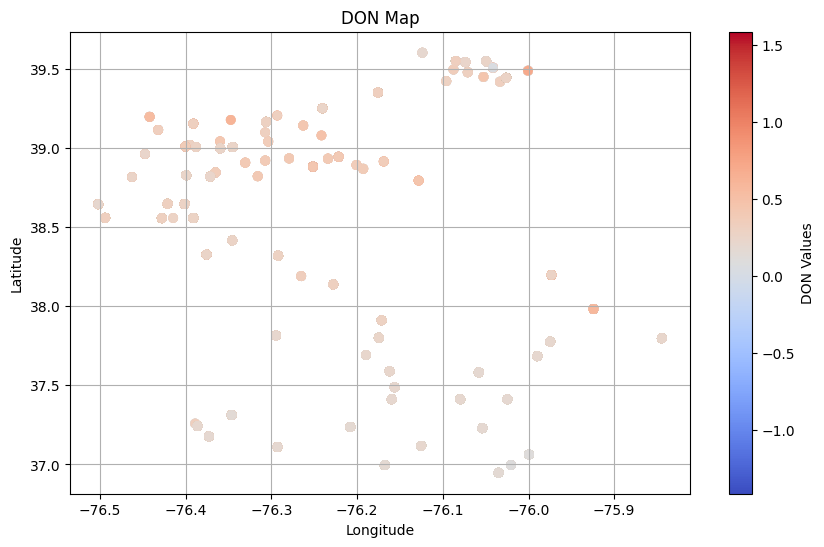

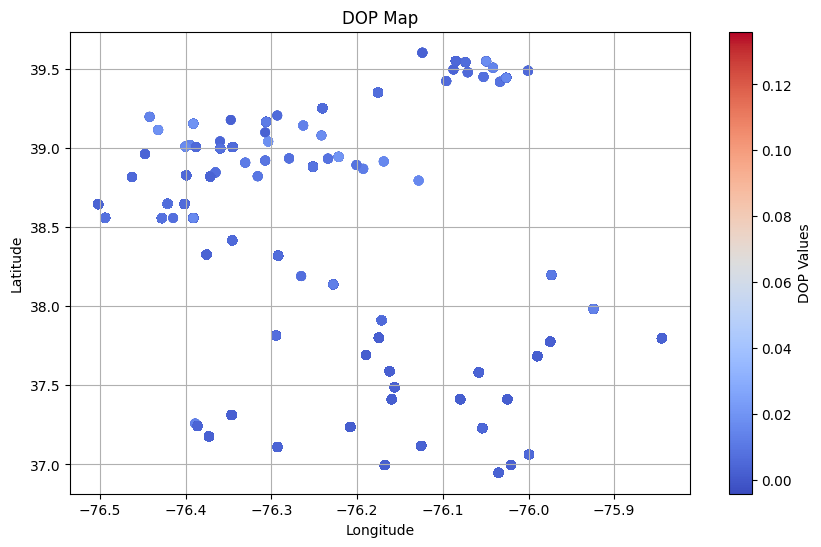

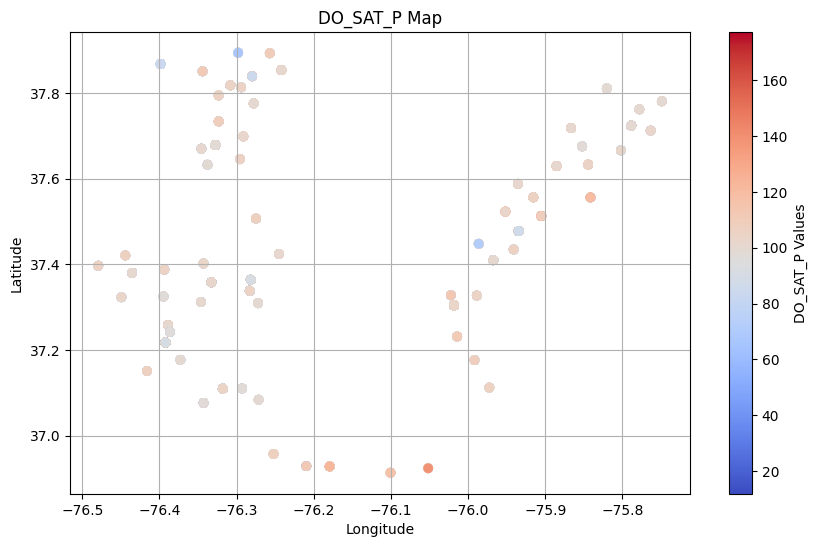

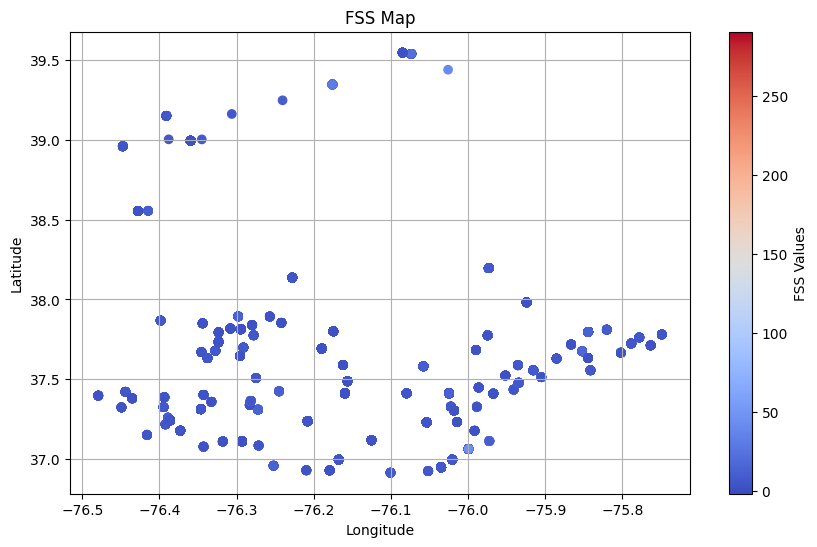

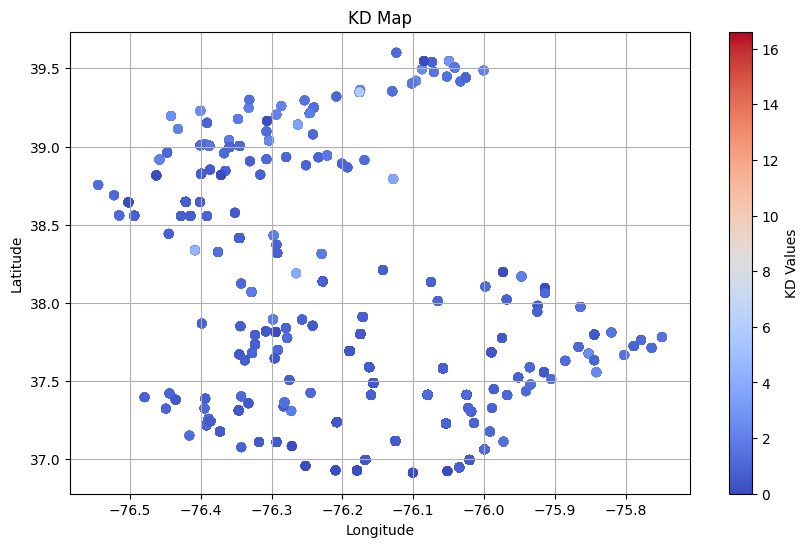

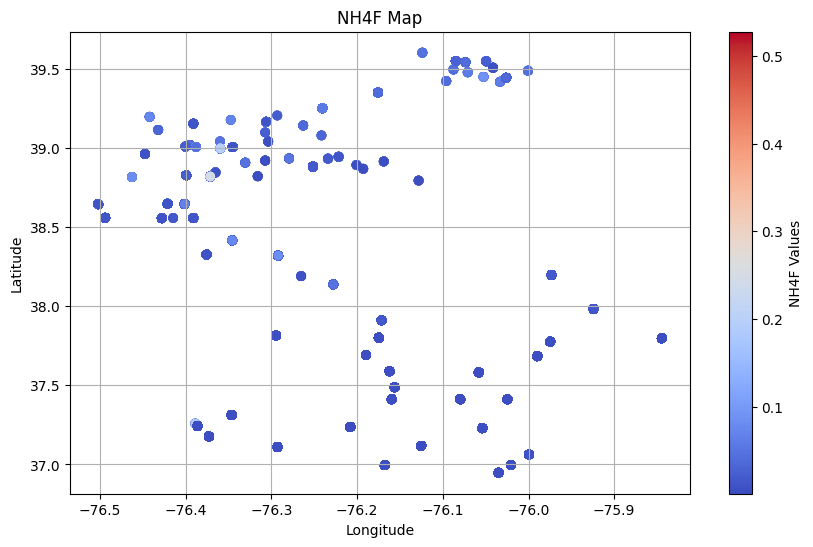

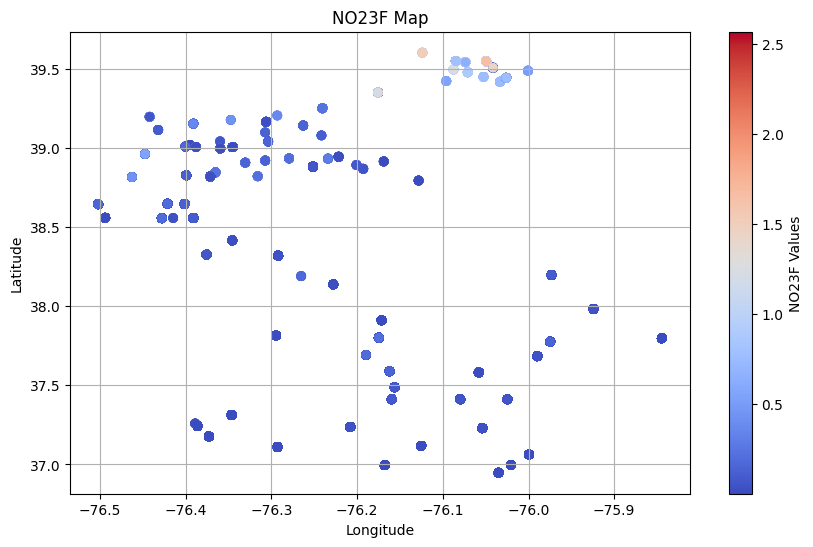

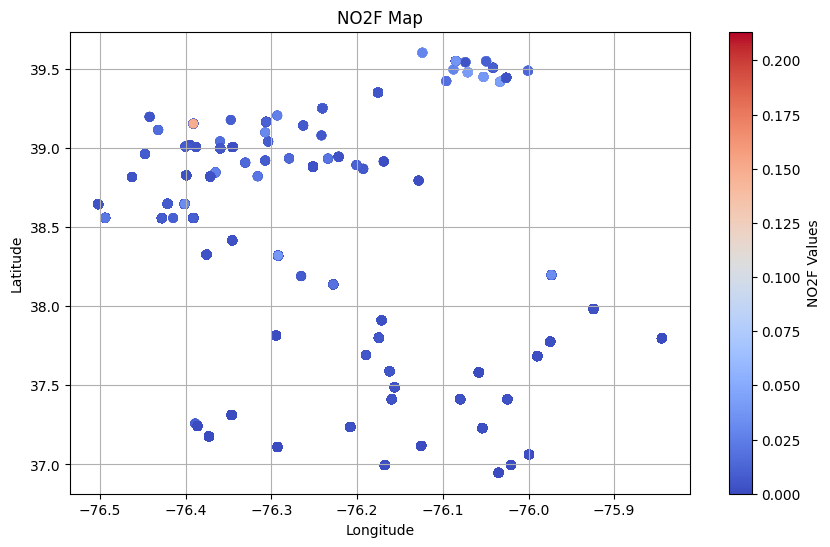

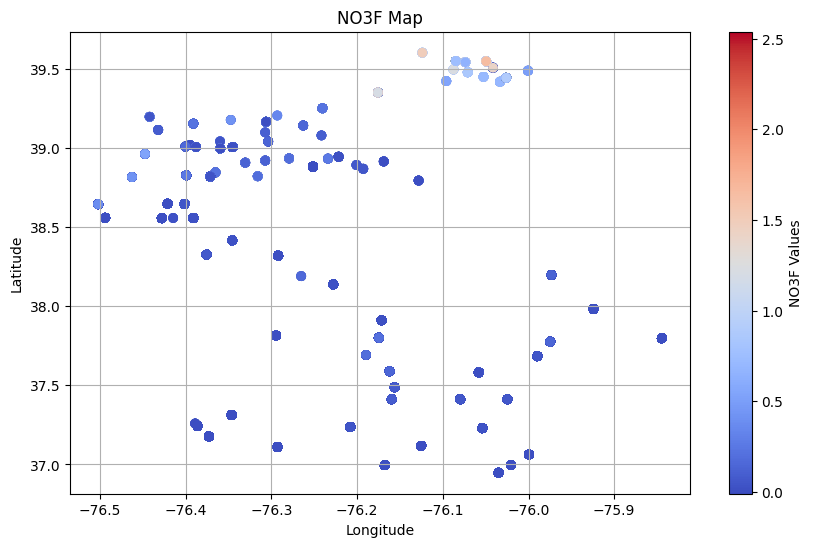

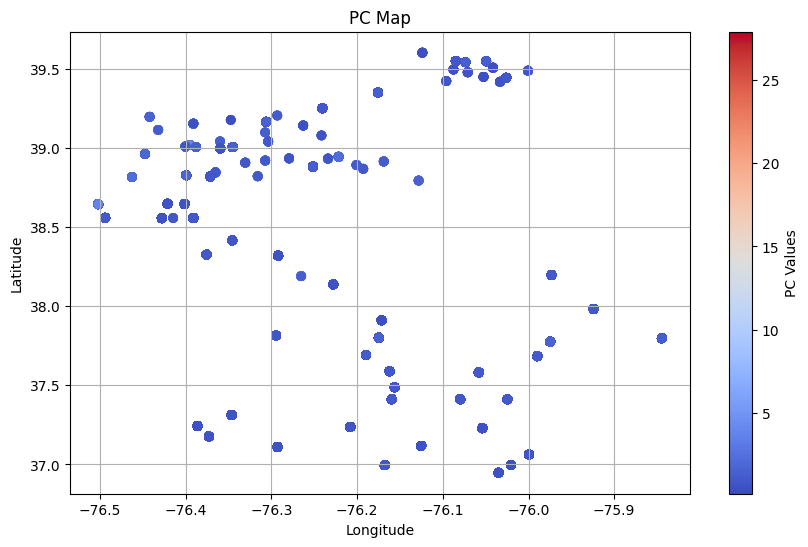

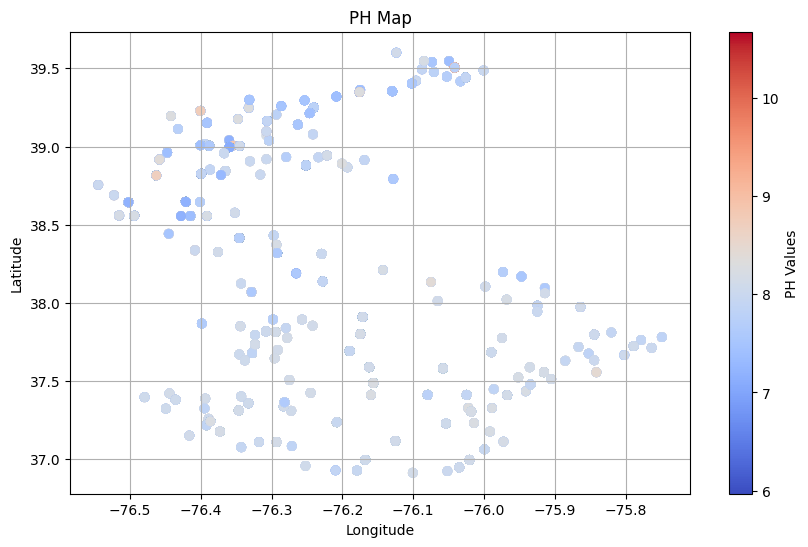

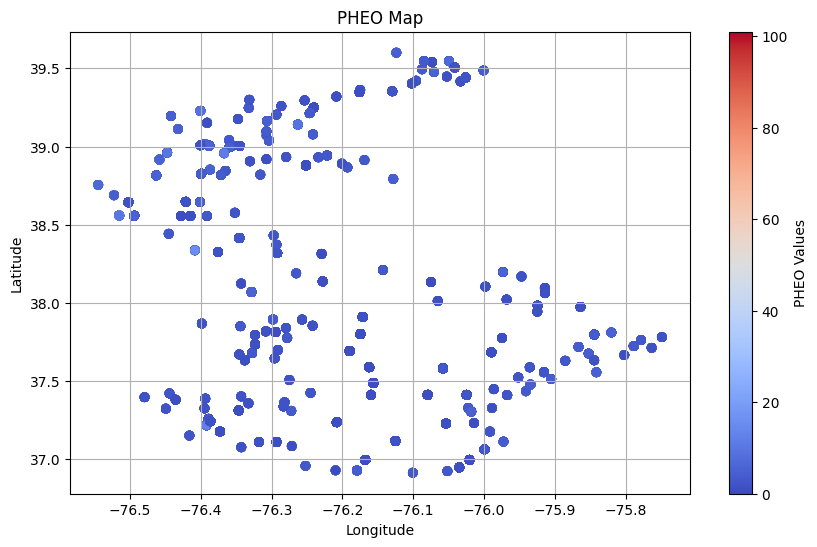

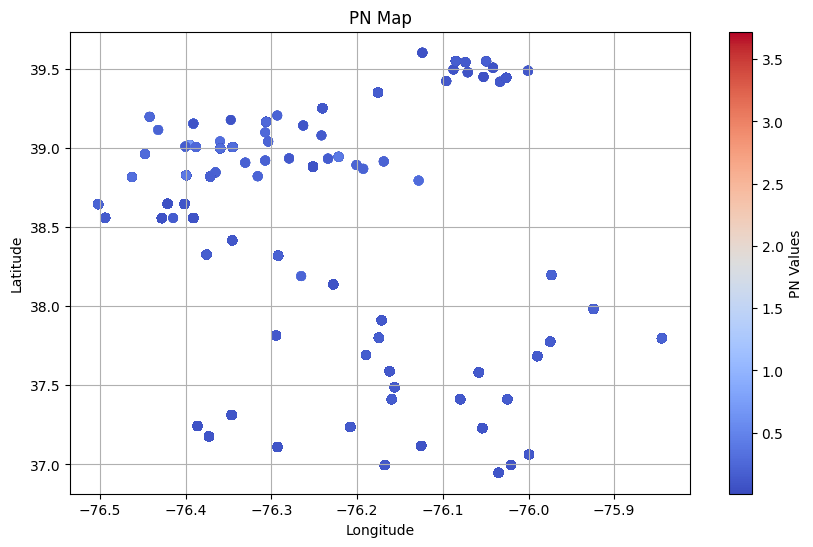

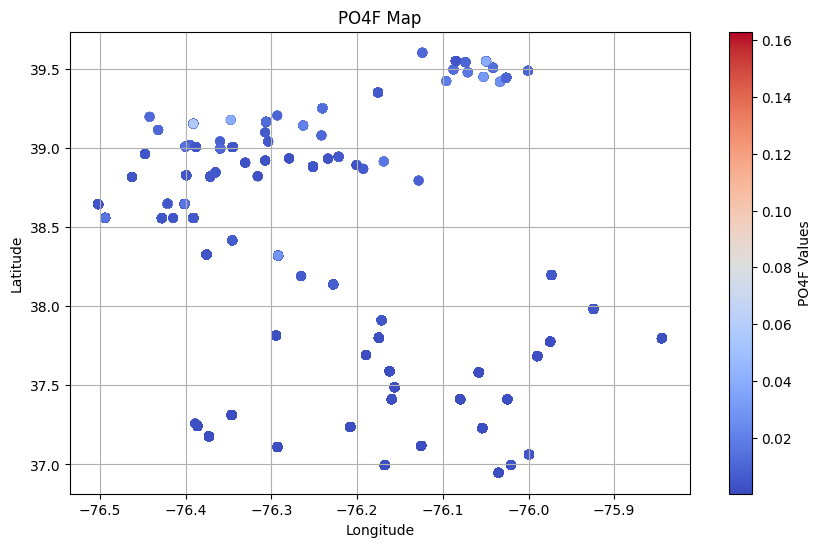

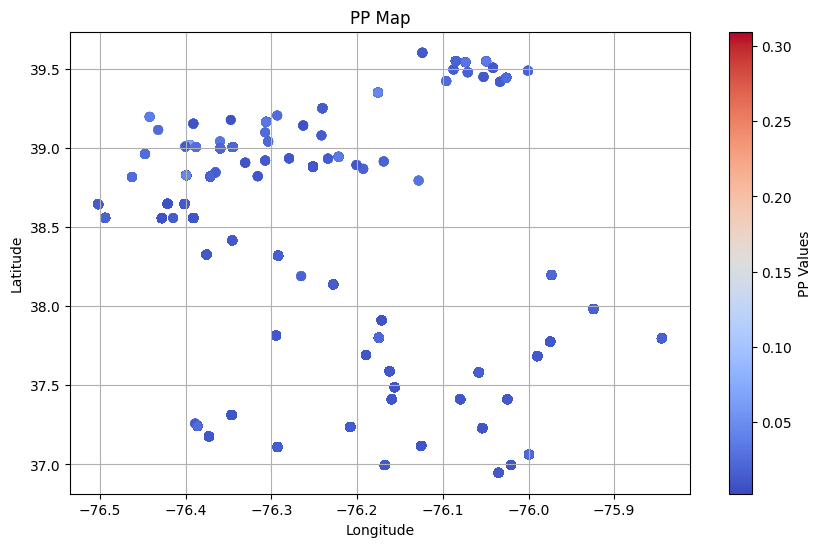

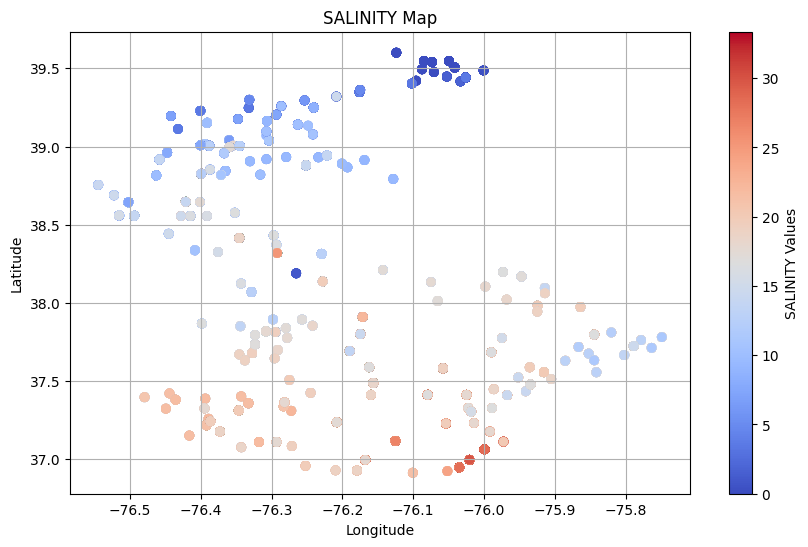

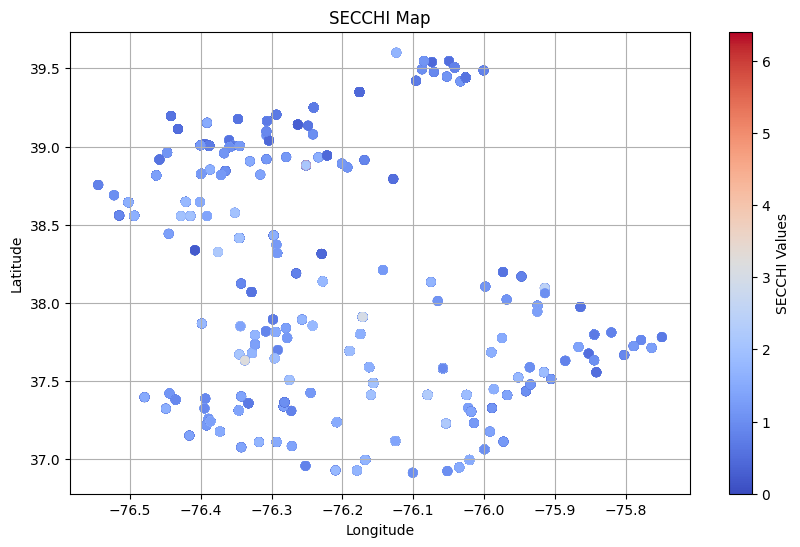

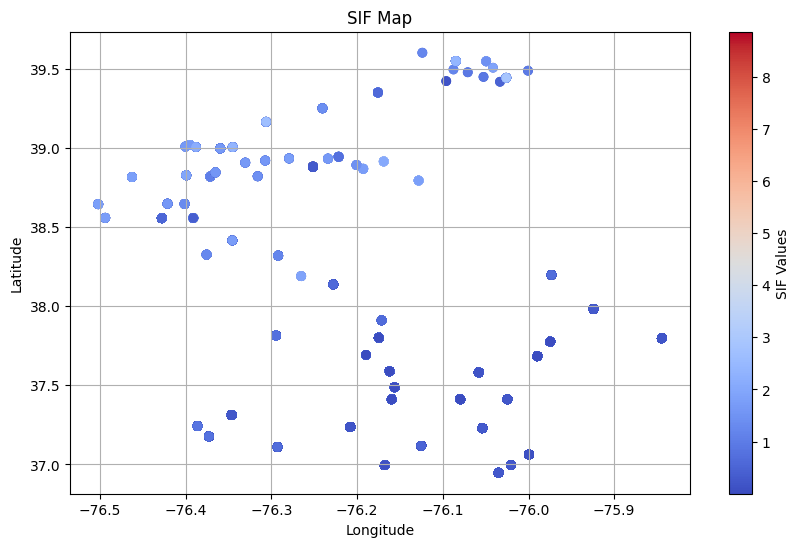

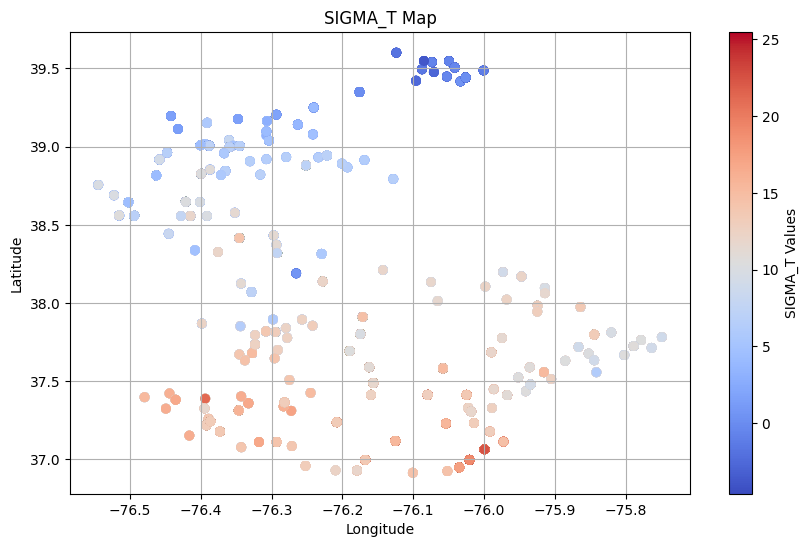

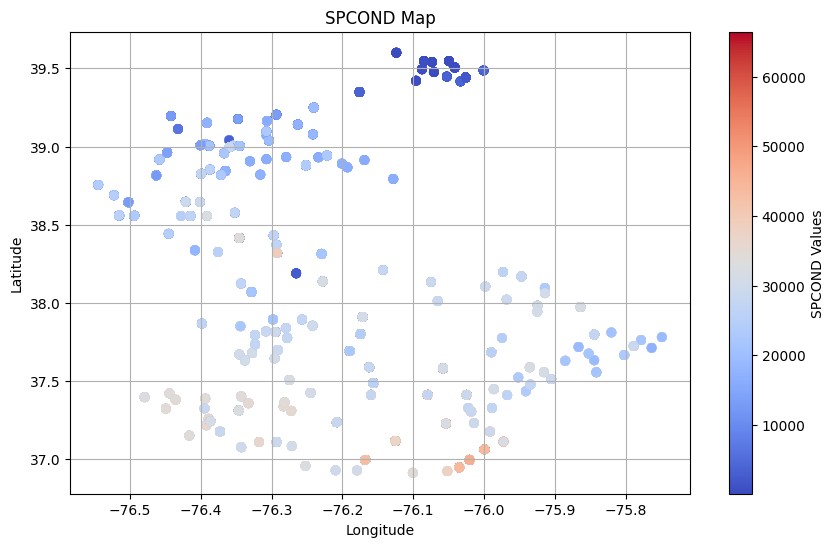

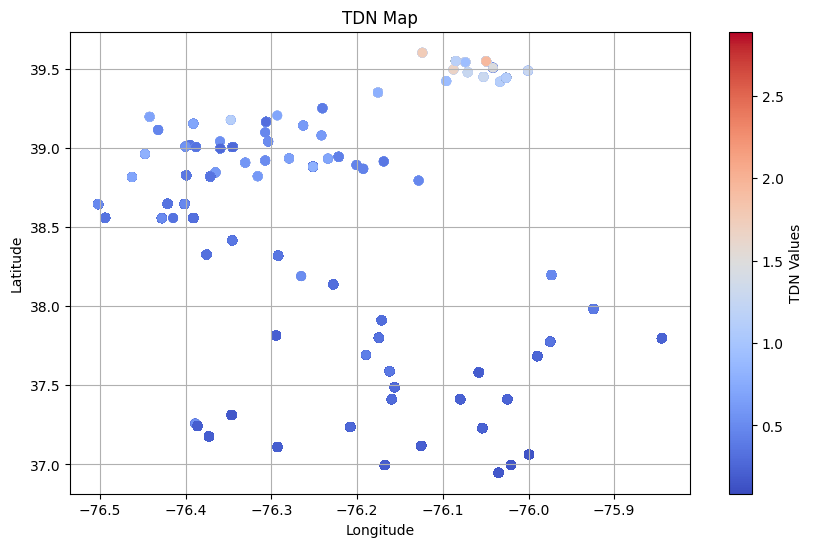

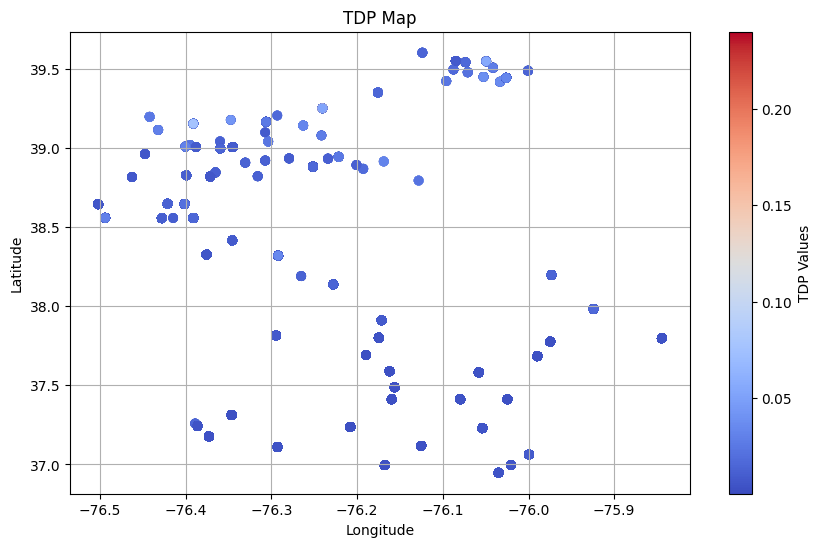

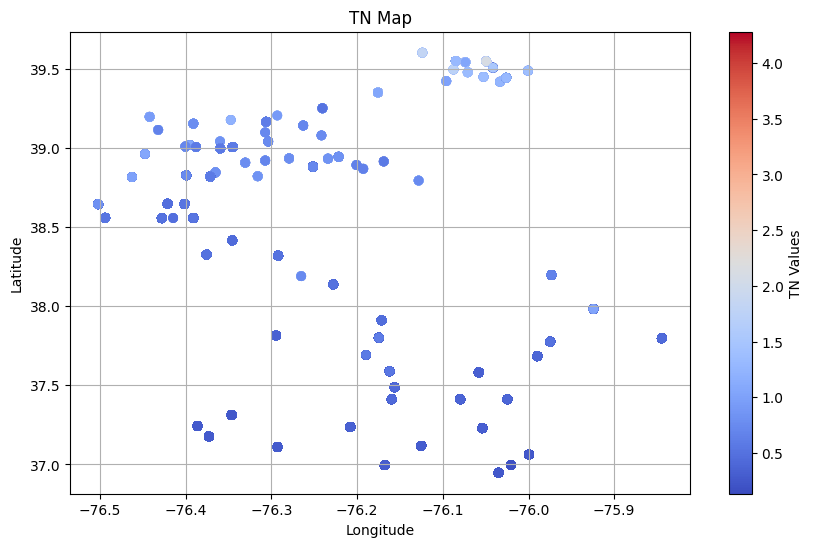

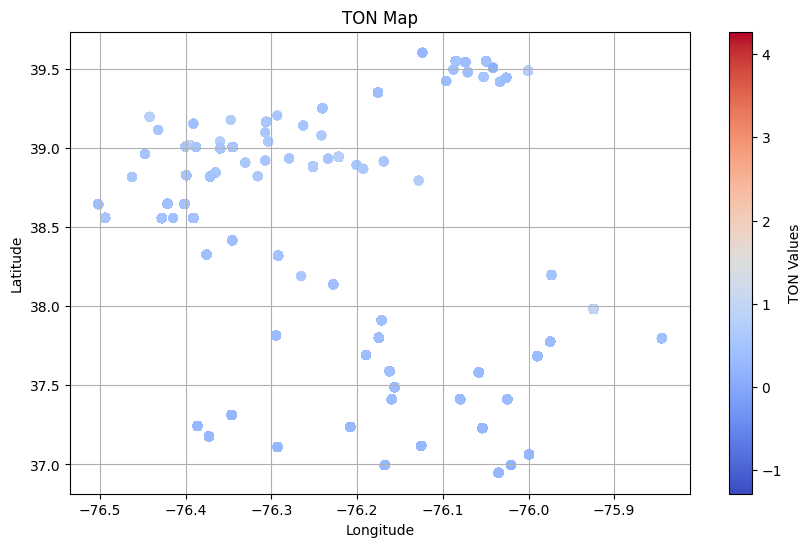

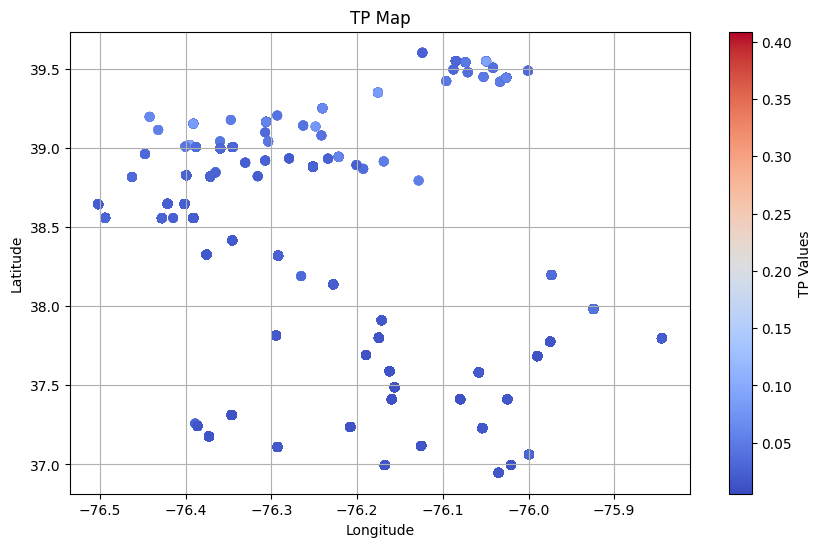

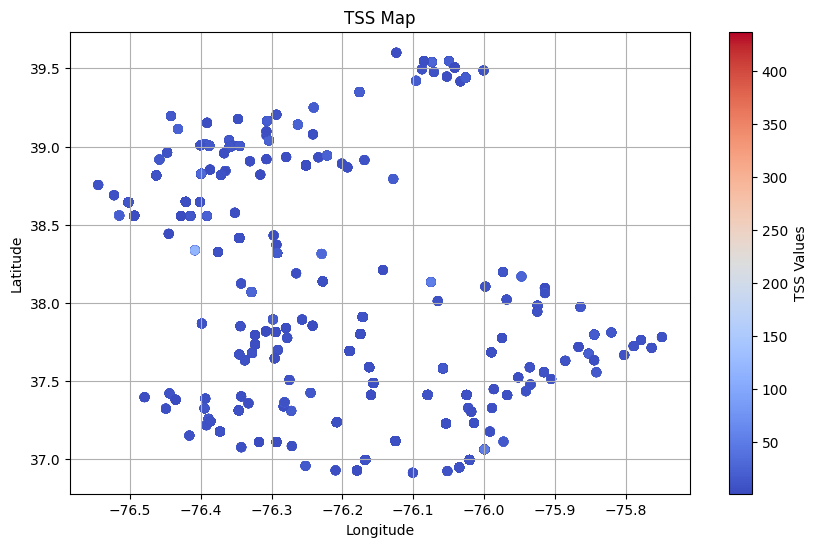

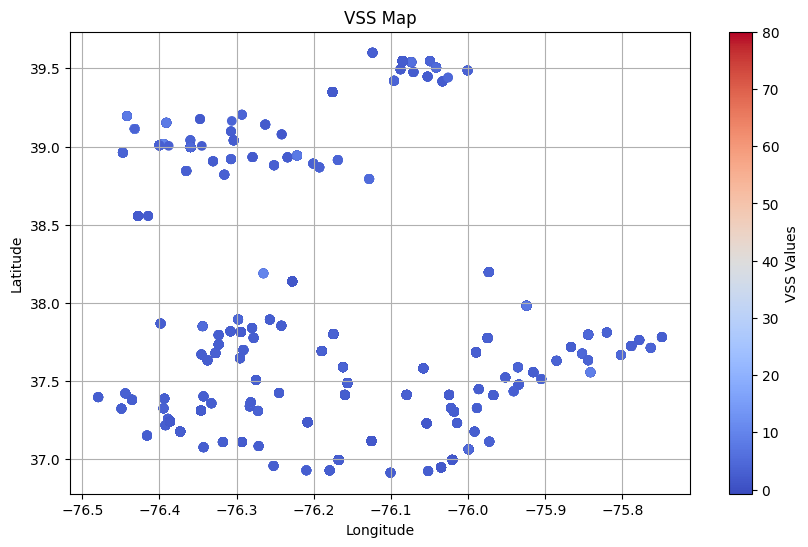

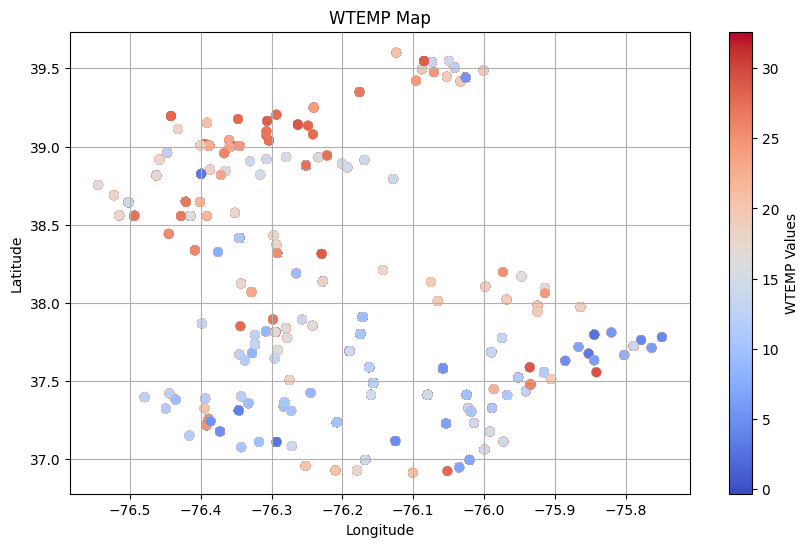

In [15]:
listparams =['DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI',
       'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS',
       'VSS', 'WTEMP']


import os
path = "../data/visualizations/waterquality"
for p in listparams:
    visualize_param_map(data_clean, p, os.path.join(path, f"{p}.png"))

In [ ]:
# df = X_train
# print("Original DataFrame:")
# print(df)

# # Identify NaNs in the DataFrame
# nan_locations = df.isna()
# print("\nLocations of NaNs in the DataFrame:")
# print(nan_locations)

# # Count NaNs in each column
# nan_count_per_column = df.isna().sum()
# print("\nCount of NaNs in each column:")
# print(nan_count_per_column)

# # Count NaNs in each row
# nan_count_per_row = df.isna().sum(axis=1)
# print("\nCount of NaNs in each row:")
# print(nan_count_per_row)

# # Rows with at least one NaN
# rows_with_nans = df[df.isna().any(axis=1)]
# print("\nRows with at least one NaN:")
# print(rows_with_nans)

# # Columns with at least one NaN
# columns_with_nans = df.columns[df.isna().any()].tolist()
# print("\nColumns with at least one NaN:")
# print(columns_with_nans)

# 3. Train an XGBoost model

In [ ]:
# Define the parameter grid to search over
# model = xgboost.XGBRegressor(
#     max_depth=3,  # Maximum depth of a tree
#     learning_rate=0.1,  # Learning rate
#     n_estimators=100,  # Number of trees
#     subsample=0.8,  # Subsample ratio of the training instances
#     colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
#     gamma=0,  # Minimum loss reduction required to make a further partition
#     min_child_weight=1,  # Minimum sum of instance weight needed in a child
#     device="cuda",
#     enable_categorical=True,
# )
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    # "LightGBM": (
    #     lgb.LGBMRegressor(),
    #     {
    #         "max_depth": [3, 5, 7],
    #         "n_estimators": [50, 100, 200],
    #         "learning_rate": [0.1, 0.01, 0.001, 0.0001]
    #     },
    # ),
    "XGBoost": (
        xgb.XGBRegressor(),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    )
    # ,
    # "MLPRegressor": (
    #     MLPRegressor(max_iter=1000),
    #     {"hidden_layer_sizes": [(50, 50), (100,)], "learning_rate_init": [0.001, 0.01]},
    # ),
}

# models = {
#     'LightGBM': lgb.LGBMRegressor(),
#     'XGBoost': xgb.XGBRegressor(),
#     'MLPRegressor': CatBoostRegressor(silent=True)
# }
# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():


    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42
    # )
    # Fit the grid search to the training data
    # grid_search.fit(X_train, y_train)
    grid_search.fit(X, y)

    # Get the best parameters
    # best_params = grid_search.best_params_
    # print(f"Best Parameters: {best_params}")

    # Create a new model with the best parameters
    # best_model = model(**best_params)
    # # Train the best model
    # best_model.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    # Predict on the test set
    # y_pred_best = best_model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred_best)

    # Evaluate the best model
    # accuracy_best = (y_pred_best == y_test).mean()
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    # plt.figure()
    explainer = shap.Explainer(model=best_model, masker=X)
    # plt.savefig(
    # f"shap_explainer_best_{model_name}_fold-{i}.png", bbox_inches="tight"
    # )
    # plt.close()
    # for i, (train_index, test_index) in enumerate(kf.split(X)):
    #     X_train, X_test, y_train, y_test = (
    #         X.iloc[train_index],
    #         X.iloc[test_index],
    #         y.iloc[train_index],
    #         y.iloc[test_index],
    #     )
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    # plt.figure()
    shap.summary_plot(shap_values, X, show=False)
    # plt.savefig(
    #     f"shap_summary_plot_best_{model_name}_fold-{i}.png", bbox_inches="tight"
    # )
    # plt.close()

In [ ]:
for shap_values in allshapvalues:
    # shap.plots.waterfall(shap_values[50], max_display=58)
    # shap.initjs()
    shap.plots.bar(shap_values, max_display=11)

    # shap.plots.beeswarm(shap_values, max_display=58)
    shap.plots.beeswarm(shap_values.abs, max_display=11)

In [ ]:

# most_freq = max(set(kfold_bestparams.items()), key=kfold_bestparams.count)

print(44.31 + 79.62)
print(38.40+89.59)
# for bestparams,msescore in zip(kfold_bestparams, mse_scores):
        
# # params = dict()
# # params["device"] = "cuda"
# # params["tree_method"] = "hist"

# model = xgboost.XGBRegressor(missing=np.nan, enable_categorical=True, device="cuda")
# model.fit(X_train, y_train)
# grid_search.cv_results_.keys()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
numerical_features = X.select_dtypes(include=['number']).columns.tolist() 
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),  # Impute missing values in numerical features
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values in categorical features
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_features)
    ])

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('mlp', MLPRegressor())
# ])

In [21]:
models = {
    # "LightGBM": (
    #     lgb.LGBMRegressor(min_gain_to_split=0.1),
    #     {
    #         "max_depth": [3, 5, 7],
    #         "n_estimators": [50, 100, 200],
    #         "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    #     },
    # ),
    "MLPRegressor": (
        MLPRegressor(max_iter=1, verbose=True),
        {
            "hidden_layer_sizes": [(50, 50), (100,)],
            "learning_rate_init": [0.001, 0.01],
        },
    ),
}


for model_name, (model, param_grid) in models.items():
    print("MODEL NAME: ", model_name)
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )
    if model_name == "MLPRegressor":
        X_calc = preprocessor.fit_transform(X)
    else:
        X_calc=X.__deepcopy__()
    grid_search.fit(X_calc, y)
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
    }

    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]["best_score"])
    kfold_bestparams.append(best_models[model_name]["best_params"])
    if model_name == "MLPRegressor":
        explainer = shap.KernelExplainer(model=best_model.predict, data=X_calc)
    else:
        explainer = shap.Explainer(model=best_model, masker=X_calc)
    shap_values = explainer(X_calc)
    allshapvalues.append(shap_values)
    explainer.__class__

    shap.summary_plot(shap_values, X_calc, show=False)

KeyboardInterrupt: 

## 4.1. Estimate the Shapley values

In [ ]:
len(allshapvalues)

In [ ]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__


In [ ]:
shap.initjs()

In [ ]:
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.bar(shap_values, max_display=10)

In [ ]:

shap.initjs()
shap.plots.force(shap_values)


In [ ]:
shap.plots.beeswarm(shap_values,max_display=58)

In [ ]:
shap.plots.scatter(shap[:, "PN"], color=shap_values)